## 1
RFM 분석을 통해 고객의 거래 데이터 기반으로

“누가 최근에, 얼마나 자주, 얼마나 많이” 활동했는지를 탐색했습니다.

이제 이를 기반으로 가입(`signup_step`), 첫 거래(`isActivation`), 재방문 빈도, 결제 금액, 추천(`isReferral`) 등의 변수를 활용해

RFM에서 확인된 **핵심 활동 고객군(VIP)이 어떤 경로로 수익을 창출하는지** 연결해 해석할 예정입니다.

---

**분석 목표**: VIP는 무엇이 다른가? (Acquisition & Activation)

**질문**:

Acquisition (획득): VIP들은 **추천(IsReferral)**으로 들어온 비율이 더 높을까? 

Activation (활동): VIP들은 가입(signup_step) 후 **첫 거래(isActivation)**까지 걸리는 시간이 더 짧을까? (가입하자마자 송금하는가?) 

Revenue (수익 패턴): VIP들은 주로 어떤 **거래 유형(type)**으로 돈을 쓰는가? (TRANSFER vs CASH_OUT)

✅ VIP 목록 로딩 완료: 9,521명
🚀 AARRR 데이터 로딩 중...
✅ 전체 데이터 로딩 완료: 114,957건

[고객 그룹 분류 결과(거래건수)]
User_Type
General (일반)       97815
VIP (Champions)    17142
Name: count, dtype: int64

=== 1. Acquisition: 추천(isReferral) 유입 효과 분석 ===
         User_Type  Referral_Rate(%)
0     General (일반)          5.415214
1  VIP (Champions)          7.913453


C:\Users\seonu\AppData\Local\Temp\ipykernel_26240\1346335590.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='User_Type', y='Referral_Rate(%)', data=acq_df, palette=['lightgray', 'orange'])


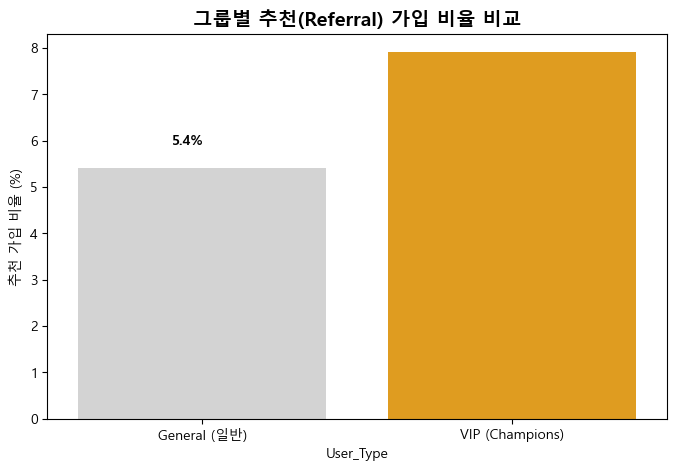


=== 2. Activation: 가입 후 첫 거래 소요 시간 ===
         User_Type       mean  median
0     General (일반)   4.672054     0.0
1  VIP (Champions)  25.491159     0.0


C:\Users\seonu\AppData\Local\Temp\ipykernel_26240\1346335590.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='User_Type', y='Activation_Time', data=first_txn, palette=['lightgray', 'orange'])


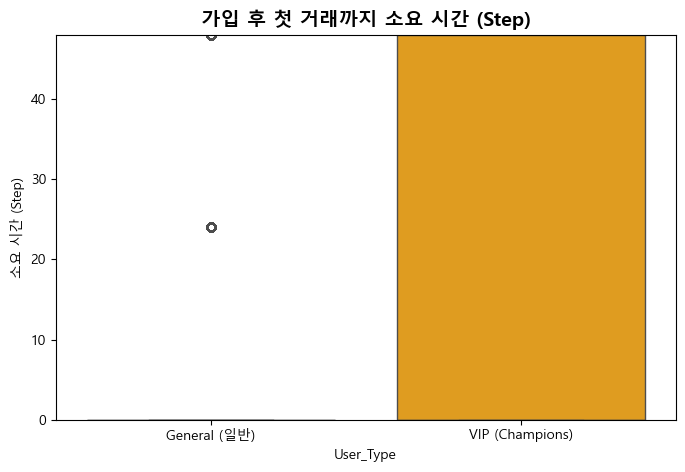


=== 3. Revenue Logic: 거래 유형(type) 선호도 ===
         User_Type      type  count  total      Ratio
6  VIP (Champions)  CASH_OUT   8041  17142  46.908179
5  VIP (Champions)   CASH_IN   5022  17142  29.296465
9  VIP (Champions)  TRANSFER   2476  17142  14.444056
8  VIP (Champions)   PAYMENT   1596  17142   9.310466
7  VIP (Champions)     DEBIT      7  17142   0.040835
3     General (일반)   PAYMENT  36845  97815  37.668047
1     General (일반)  CASH_OUT  32700  97815  33.430455
0     General (일반)   CASH_IN  20492  97815  20.949752
4     General (일반)  TRANSFER   7086  97815   7.244288
2     General (일반)     DEBIT    692  97815   0.707458


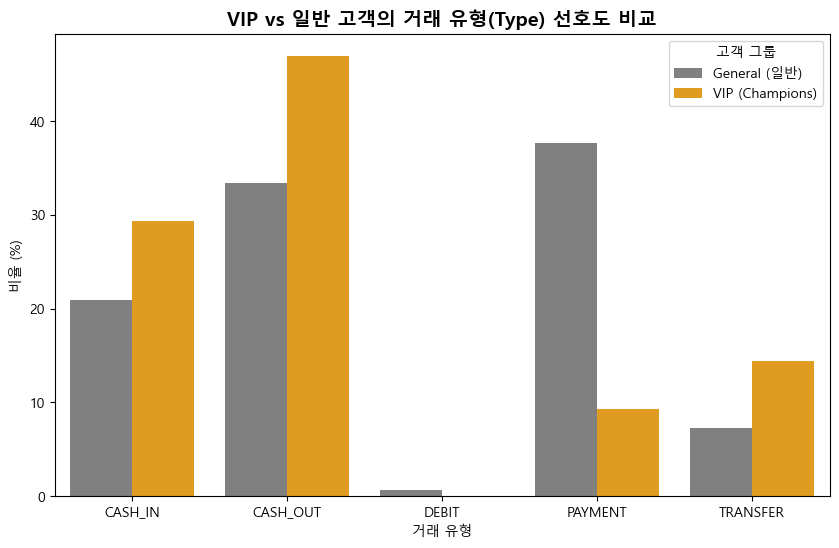

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

# ==========================================
# [Windows 전용] 한글 폰트 설정
# ==========================================
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1) 데이터 준비
# ==========================================
# 1-1. 이전에 뽑아둔 VIP 리스트 로딩
try:
    vip_df = pd.read_csv("vip_customers_list.csv")
    vip_list = vip_df['nameOrig'].unique().tolist()
    print(f"✅ VIP 목록 로딩 완료: {len(vip_list):,}명")
except FileNotFoundError:
    print("❌ 오류: 'vip_customers_list.csv' 파일이 없습니다. 이전 단계 코드를 먼저 실행해주세요.")
    vip_list = []

# 1-2. DB에서 AARRR 분석용 데이터 로딩
DB_PATH = "paysim.db"
TABLE   = "PaySim"  # PaySim 테이블 사용

engine = create_engine(f"sqlite:///{DB_PATH}")

print("🚀 AARRR 데이터 로딩 중...")

# [수정 포인트] 컬럼명을 DB 스키마(isReferral, isActivation)와 정확히 일치시킴
query = text(f"""
    SELECT 
        step, nameOrig, amount, type,
        signup_step, isActivation, isReferral
    FROM {TABLE}
""")

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

print(f"✅ 전체 데이터 로딩 완료: {len(df):,}건")

# ==========================================
# 2) 데이터 전처리: VIP vs Non-VIP 구분
# ==========================================
# nameOrig가 vip_list에 있으면 'VIP', 아니면 'General'로 마킹
df['User_Type'] = df['nameOrig'].apply(lambda x: 'VIP (Champions)' if x in vip_list else 'General (일반)')

print("\n[고객 그룹 분류 결과(거래건수)]")
print(df['User_Type'].value_counts())

# ==========================================
# 3) Acquisition (획득): 추천(Referral) 유입 효과
# ==========================================
print("\n=== 1. Acquisition: 추천(isReferral) 유입 효과 분석 ===")

# [수정 포인트] IsReferral -> isReferral
user_acquisition = df[['nameOrig', 'User_Type', 'isReferral']].drop_duplicates()

# 그룹별 추천 가입 비율 계산
acq_stat = user_acquisition.groupby('User_Type')['isReferral'].mean() * 100
acq_df = acq_stat.reset_index()
acq_df.columns = ['User_Type', 'Referral_Rate(%)']

print(acq_df)

# [시각화]
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='User_Type', y='Referral_Rate(%)', data=acq_df, palette=['lightgray', 'orange'])
plt.title("그룹별 추천(Referral) 가입 비율 비교", fontsize=14, fontweight='bold')
plt.ylabel("추천 가입 비율 (%)")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x()+0.3, p.get_height()+0.5), fontweight='bold')
plt.show()


# ==========================================
# 4) Activation (활성): 첫 거래 속도
# ==========================================
print("\n=== 2. Activation: 가입 후 첫 거래 소요 시간 ===")

# [수정 포인트] IsActivation -> isActivation (혹시 몰라 소문자로 통일)
first_txn = df[df['isActivation'] == 1].copy()

# 활성화 시간 = (거래 시점 step) - (가입 시점 signup_step)
first_txn['Activation_Time'] = (first_txn['step'] - first_txn['signup_step']).clip(lower=0)

# 그룹별 평균 활성화 시간 비교
act_stat = first_txn.groupby('User_Type')['Activation_Time'].agg(['mean', 'median']).reset_index()
print(act_stat)

# [시각화]
plt.figure(figsize=(8, 5))
sns.boxplot(x='User_Type', y='Activation_Time', data=first_txn, palette=['lightgray', 'orange'])
plt.title("가입 후 첫 거래까지 소요 시간 (Step)", fontsize=14, fontweight='bold')
plt.ylabel("소요 시간 (Step)")
plt.ylim(0, first_txn['Activation_Time'].quantile(0.95)) # 이상치 제외하고 보기
plt.show()


# ==========================================
# 5) Revenue/Behavior: 선호 거래 유형
# ==========================================
print("\n=== 3. Revenue Logic: 거래 유형(type) 선호도 ===")

type_counts = df.groupby(['User_Type', 'type']).size().reset_index(name='count')
total_counts = df.groupby('User_Type')['type'].count().reset_index(name='total')
type_ratios = type_counts.merge(total_counts, on='User_Type')
type_ratios['Ratio'] = (type_ratios['count'] / type_ratios['total']) * 100

print(type_ratios.sort_values(['User_Type', 'Ratio'], ascending=False))

# [시각화]
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='Ratio', hue='User_Type', data=type_ratios, palette=['gray', 'orange'])
plt.title("VIP vs 일반 고객의 거래 유형(Type) 선호도 비교", fontsize=14, fontweight='bold')
plt.ylabel("비율 (%)")
plt.xlabel("거래 유형")
plt.legend(title="고객 그룹")
plt.show()

### 분석결과

**1. 획득(Acquisition): "VIP는 추천을 타고 온다"**

- 결과: VIP 그룹의 추천 가입 비율(약 7.9%)이 일반 그룹(5.4%)보다 약 1.5배 높습니다.

- 해석: "좋은 고객이 좋은 고객을 데려온다"는 가설이 입증되었습니다. VIP들은 지인의 추천을 통해 유입될 확률이 높습니다.

- 전략: VIP 고객에게 **"친구 초대 보상(Referral Bonus)"**을 강화하면, 마케팅 비용을 아끼면서도 양질의 신규 고객을 확보할 수 있습니다.

**2. 활동(Activation): "VIP는 준비 시간이 필요하다?"**

- 결과: 일반 고객(회색)은 박스가 납작한데(가입 즉시 거래), VIP(주황색)는 박스가 위아래로 깁니다(시간 편차가 큼).

- 해석:

일반 고객: 가입하자마자 소액 결제(PAYMENT)만 하고 끝나는 경우가 많아 '즉시 반응'이 나옵니다.

VIP 고객: 주 거래 유형이 CASH_IN(입금)이나 TRANSFER(송금)입니다. 이런 거래는 계좌 연동이나 충전이 필요해서 첫 거래까지 시간이 조금 더 걸리거나, 사람마다 편차가 클 수 있습니다.

- 전략: VIP가 될 가능성이 있는 유저(입금 시도 등)에게는 "조금 복잡해도 괜찮아요, 혜택이 있어요"라는 온보딩 가이드가 필요합니다.

**3. 행동(Behavior): "일반인은 지갑, VIP는 은행처럼 쓴다" (⭐ 가장 중요)**

- 결과:

일반 고객: PAYMENT(결제) 비중이 압도적으로 높습니다. (단순 소비용)

VIP 고객: CASH_IN(입금), CASH_OUT(출금) 비중이 높고, TRANSFER도 더 많이 합니다. PAYMENT 비중은 매우 낮습니다.

- 해석: VIP들은 이 서비스를 단순 결제 앱이 아니라, 돈을 넣고 빼고 보내는 **'금융 허브(은행)'**처럼 활용하고 있습니다. 자금의 유동성(Liquidity)을 담당하는 핵심 고객들입니다.

---

**분석 목표** : **"VIP는 금융 허브처럼 서비스를 쓴다"**는 것을 알았으니, 이들이 얼마나 오래 남아있는지(Retention), 그리고 돈이 되는 행동을 얼마나 반복하는지(Revenue) 분석

**질문**:

Retention (유지): VIP는 일반 고객보다 **수명(Life-time)**이 얼마나 긴가?

Revenue (수익): VIP 1명이 일반 고객 몇 명분의 **매출(Amount)**을 만드는가? (ARPPU)

Stickiness (고착도): VIP는 **일주일(Step 기준)**에 몇 번이나 접속하는가?

🚀 Retention & Revenue 데이터 분석 시작...
✅ 데이터 집계 완료: 99,999명

=== 1. Retention: 고객 활동 수명(Duration) 비교 ===
                      mean  50%    max
User_Type                             
General (일반)      1.947247  0.0  119.0
VIP (Champions)  19.210587  0.0   96.0


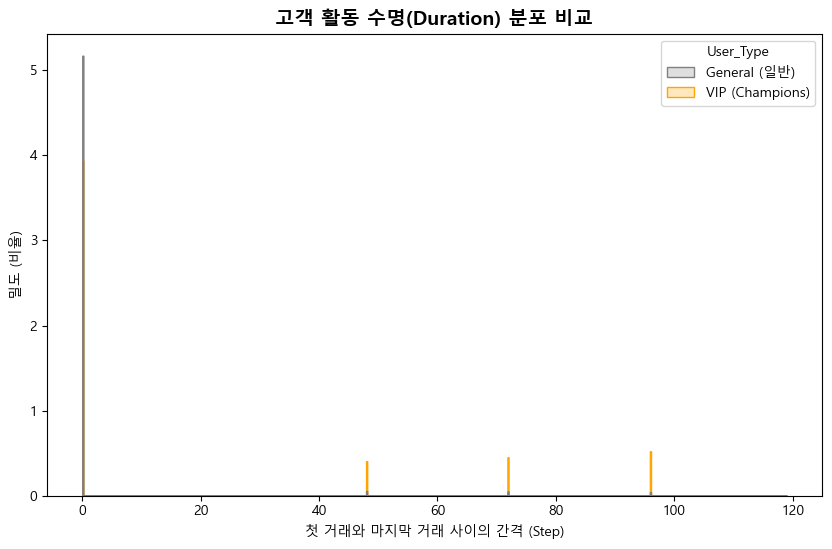


=== 2. Revenue: 인당 평균 거래액(ARPPU) 비교 ===
💰 VIP 1명은 일반 고객 3.6명분의 가치를 가집니다.
         User_Type          ARPPU
0     General (일반)  166299.495559
1  VIP (Champions)  602338.069623


C:\Users\seonu\AppData\Local\Temp\ipykernel_26240\516342879.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='User_Type', y='ARPPU', data=arppu, palette=['lightgray', 'orange'])


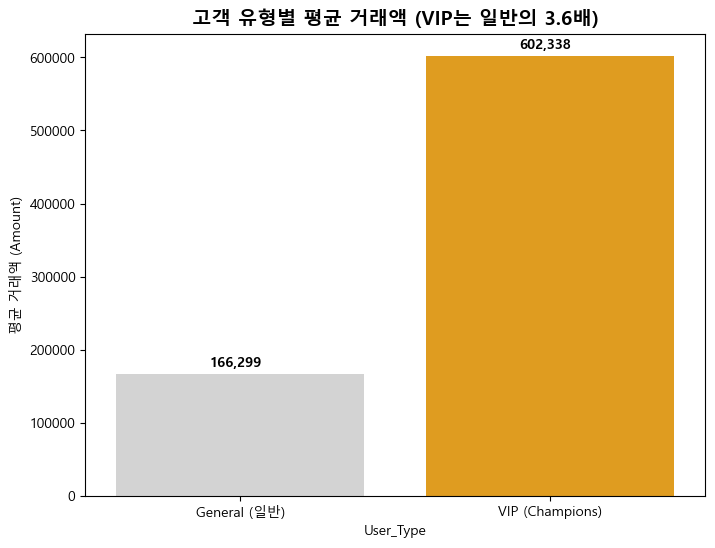

C:\Users\seonu\AppData\Local\Temp\ipykernel_26240\516342879.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='User_Type', y='txn_count', data=user_stat, palette=['lightgray', 'orange'], showfliers=False) # 이상치 제외하고 보기


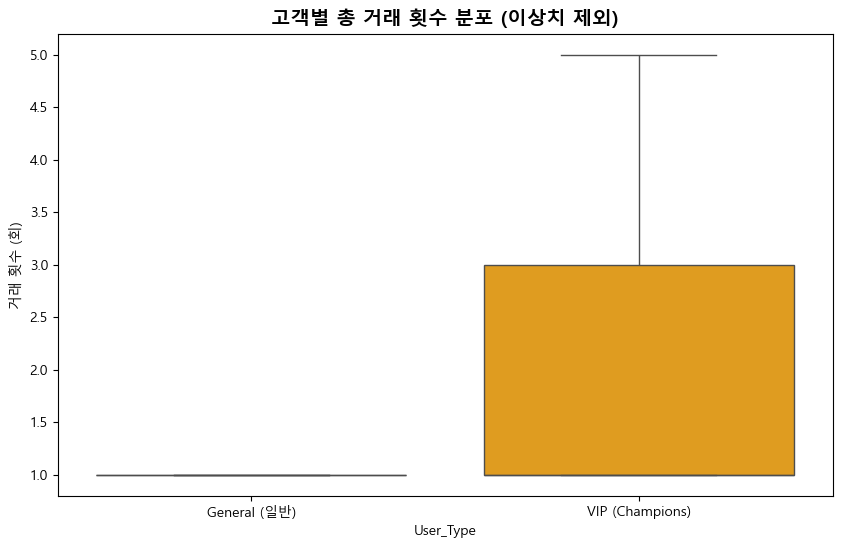

In [4]:
#위에서 데이터 준비 (VIP 목록 로딩) 했다고 가정
print("🚀 Retention & Revenue 데이터 분석 시작...")

# ==========================================
# 1) Retention & Revenue 데이터 쿼리
# ==========================================
# 고객별 '활동 기간'과 '총 거래 금액'을 계산
query = text(f"""
    SELECT 
        nameOrig,
        COUNT(*) as txn_count,                  -- 총 거래 횟수
        SUM(amount) as total_amount,            -- 총 거래 금액 (LTV 근사치)
        MIN(step) as first_step,                -- 첫 활동 시점
        MAX(step) as last_step,                 -- 마지막 활동 시점
        (MAX(step) - MIN(step)) as duration     -- 활동 수명 (Step)
    FROM {TABLE}
    GROUP BY nameOrig
""")

with engine.connect() as conn:
    user_stat = pd.read_sql(query, conn)

# VIP 여부 마킹
user_stat['User_Type'] = user_stat['nameOrig'].apply(lambda x: 'VIP (Champions)' if x in vip_list else 'General (일반)')

print(f"✅ 데이터 집계 완료: {len(user_stat):,}명")

# ==========================================
# 2) Retention 분석: 고객 수명(Duration) 비교
# ==========================================
print("\n=== 1. Retention: 고객 활동 수명(Duration) 비교 ===")

# 수명 통계
life_stat = user_stat.groupby('User_Type')['duration'].describe()
print(life_stat[['mean', '50%', 'max']])

# [시각화] 수명 분포 (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(data=user_stat, x='duration', hue='User_Type', element="step", stat="density", common_norm=False, palette=['gray', 'orange'])
plt.title("고객 활동 수명(Duration) 분포 비교", fontsize=14, fontweight='bold')
plt.xlabel("첫 거래와 마지막 거래 사이의 간격 (Step)")
plt.ylabel("밀도 (비율)")
plt.show()

# ==========================================
# 3) Revenue 분석: 고객 가치(LTV) 비교
# ==========================================
print("\n=== 2. Revenue: 인당 평균 거래액(ARPPU) 비교 ===")

# 인당 평균 거래액 계산
arppu = user_stat.groupby('User_Type')['total_amount'].mean().reset_index()
arppu.columns = ['User_Type', 'ARPPU']

# 몇 배 차이인지 계산
vip_arppu = arppu.loc[arppu['User_Type']=='VIP (Champions)', 'ARPPU'].values[0]
gen_arppu = arppu.loc[arppu['User_Type']=='General (일반)', 'ARPPU'].values[0]
multiple = vip_arppu / gen_arppu

print(f"💰 VIP 1명은 일반 고객 {multiple:.1f}명분의 가치를 가집니다.")
print(arppu)

# [시각화] ARPPU 비교 (Bar Chart)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='User_Type', y='ARPPU', data=arppu, palette=['lightgray', 'orange'])
plt.title(f"고객 유형별 평균 거래액 (VIP는 일반의 {multiple:.1f}배)", fontsize=14, fontweight='bold')
plt.ylabel("평균 거래액 (Amount)")

# 막대 위에 실제 금액 표시 (천 단위 콤마)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x()+0.3, p.get_height()), xytext=(0, 5), textcoords='offset points', fontweight='bold')

plt.show()

# ==========================================
# 4) [심화] Stickiness: 활동 주기 분석
# ==========================================
# 거래 횟수(Frequency) 분포 비교
plt.figure(figsize=(10, 6))
sns.boxplot(x='User_Type', y='txn_count', data=user_stat, palette=['lightgray', 'orange'], showfliers=False) # 이상치 제외하고 보기
plt.title("고객별 총 거래 횟수 분포 (이상치 제외)", fontsize=14, fontweight='bold')
plt.ylabel("거래 횟수 (회)")
plt.show()

### 분석결과

**1. 왜 수명(Duration) 중앙값이 둘 다 0.0일까?**

- 이유: Duration = 마지막 거래 - 첫 거래입니다.

- 현상: 일반 고객뿐만 아니라 VIP조차도 대다수는 **"한 번 거래하고 끝(One-off)"**이거나 "한 시간(1 Step) 내에 여러 번 거래하고 사라지는" 패턴이라는 뜻입니다.

- 반전 (평균의 차이):

중앙값은 0이지만, **평균(Mean)**은

일반: 1.9 vs VIP: 19.2 (약 10배 차이!)

- 해석: 일반 고객은 진짜 1회성인데, VIP 중 일부는 며칠 뒤에 "다시 돌아오는(Retain)" 패턴이 분명히 존재한다는 신호입니다. (히스토그램의 주황색 작은 기둥들이 48, 96 step 쯤을 보면 이틀 간격으로 돌아오는 찐 팬들이 있다는 뜻입니다.)

**2. 매출(Revenue): "결국 돈이 말해준다" (⭐ 가장 중요)**

- VIP (602,338원) vs 일반 (166,299원)

3.6배 차이: VIP는 오래 머물지는 않더라도, 한 번 왔을 때 일반인 월급의 3.6배를 쓰고 갑니다.

- 결론: 우리 VIP는 "매일 출석하는 성실한 고객"이 아니라, "가끔 와서 거액을 쏘고 가는 큰손(Whale)" 스타일입니다.

**3. 거래 횟수(Frequency): "1번과 3번의 차이는 거대하다"**

- 일반 고객 (회색 선): 그냥 바닥에 딱 붙어있음. 거의 100%가 딱 1번 거래합니다.

VIP 고객 (주황 박스): 박스가 1~3회에 걸쳐 있고 수염이 5회까지 뻗어 있습니다.

- 핵심 인사이트: 이 비즈니스에서는 "고객을 딱 1번만 더 거래하게 만들어도(2회 이상)" 바로 상위 1% VIP가 될 가능성이 높습니다. **재구매 유도(Retargeting)**가 가장 시급한 과제입니다.

---

>**VIP의 페르소나(Persona)**
>
>"지인 추천(Referral)으로 들어와서, 가입 후 간을 좀 보다가, 한두 번의 송금(Transfer)으로 일반인보다 3.6배 많은 돈을 '굵고 >짧게' 쓰고 나가는 큰손."

---

## 2
다음 단계에서는 전체 사용자 흐름 전반을
**AARRR 퍼널 분석(획득–활성–유지–수익–추천)** 모델에 따라 분석합니다.
 
각 단계별 전환율과 유지율을 파악하고,
고객이 어떤 경로를 통해 유입되고, 얼마나 지속적으로 참여하며,
최종적으로 어떤 가치를 만들어내는지 단계별로 살펴보겠습니다.



---

**PaySim 데이터 기반 AARRR 퍼널 지표 정의**

Acquisition (획득): 전체 가입 고객 수 (Total Unique Users)

Activation (활성): 가입 후 첫 거래를 완료한 고객 (isActivation = 1)

Retention (유지): 2회 이상 거래를 수행한 고객 (재방문/재구매)

Revenue (수익): 매출을 발생시킨 총 금액 및 인당 평균 매출 (ARPU)

Referral (추천): 추천을 통해 유입된 고객의 비율 (isReferral = 1)

**PaySim데이터의 허점에 의한 기본 설정**

**1. 수익/추천 연결 문제**

- 이유: 통상적인 **'퍼널(Funnel) 차트'**는 **사람 수(N명)**가 줄어드는 과정을 그립니다.

- 수익(Revenue): '사람 수'가 아니라 **'금액(돈)'**입니다. 퍼널의 막대 길이로 표현하기 애매해서 보통 별도 지표로 봅니다.

- 추천(Referral): isReferral 변수는 "내가 친구를 초대한 여부"가 아니라 **"내가 초대를 받고 들어왔는지(수동태)"**를 나타냅니다. 즉, 퍼널의 마지막 단계(내가 남을 추천함)가 아니라 **맨 처음 단계(획득 경로)**에 해당하는 변수라서 뒤로 연결하지 않았습니다.

- 해결: 하지만 **"돈을 낸 사람 수(Paying User)"**로 정의하면 퍼널에 넣을 수 있습니다. (점점 줄어드는 형태로는 안나옴)

**2. Fraud=1(사기)을 포함하면 퍼널 논리가 깨짐**

- 이유: 사기꾼들은 시스템을 속이기 위해 **엄청난 금액을 짧은 시간에 반복 거래(High Retention, High Revenue)**합니다. 이들이 포함되면 "와! 우리 서비스 재구매율도 높고 매출도 대박이네!"라고 착시 현상을 일으킵니다.

- 결론: 건전한 비즈니스 지표를 보려면 WHERE isFraud = 0 조건을 반드시 걸어야 합니다.

**3. isActivation이 0/1이라서 생기는 연결문제 있나?**

- isActivation=1인 사람만 다음 단계(Retention)로 넘어가는 조건으로 쓰면 되므로, 퍼널 연결에는 아주 좋은 변수입니다.

**4. PaySim의 'amount' 합계를 '수익(Revenue)'으로 봐도 되나?**
**엄밀히 말하면: 거래액(TPV, Total Payment Volume)**입니다.

- 기업 입장: 토스나 카카오페이 같은 송금 서비스는 거래액의 **일부(수수료, 예: 0.5~1%)**를 매출로 잡습니다.

- 분석적 허용: 하지만 시뮬레이션 데이터이고 수수료 정보가 없으므로, **"거래액(amount)이 클수록 회사의 수익도 비례해서 커진다"**고 가정하고 amount를 **수익 지표(Proxy)**로 사용하는 것이 일반적입니다.

- 보고서에는 "매출(Revenue)" 대신 "총 거래액(TPV)"이라고 표기하는 것이 정확합니다.

🚀 AARRR 분석 시작 (Revenue = Amount 연결)...
✅ 데이터 로드 완료: 99,858명

=== 📊 AARRR 퍼널 단계별 수치 ===
                   Stage         Value   Type
0   1. Acquisition\n(가입)  9.985800e+04   User
1  2. Activation\n(첫 거래)  4.183400e+04   User
2    3. Retention\n(재거래)  4.990000e+03   User
3    4. Revenue\n(총 거래액)  3.594067e+09  Money

💰 Retention 단계 유저의 총 매출 기여액: 3,594,067,375원
👤 재구매 유저 1인당 평균 매출(ARPPU): 720,254원


C:\Users\seonu\AppData\Local\Temp\ipykernel_26240\4045440667.py:113: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\seonu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


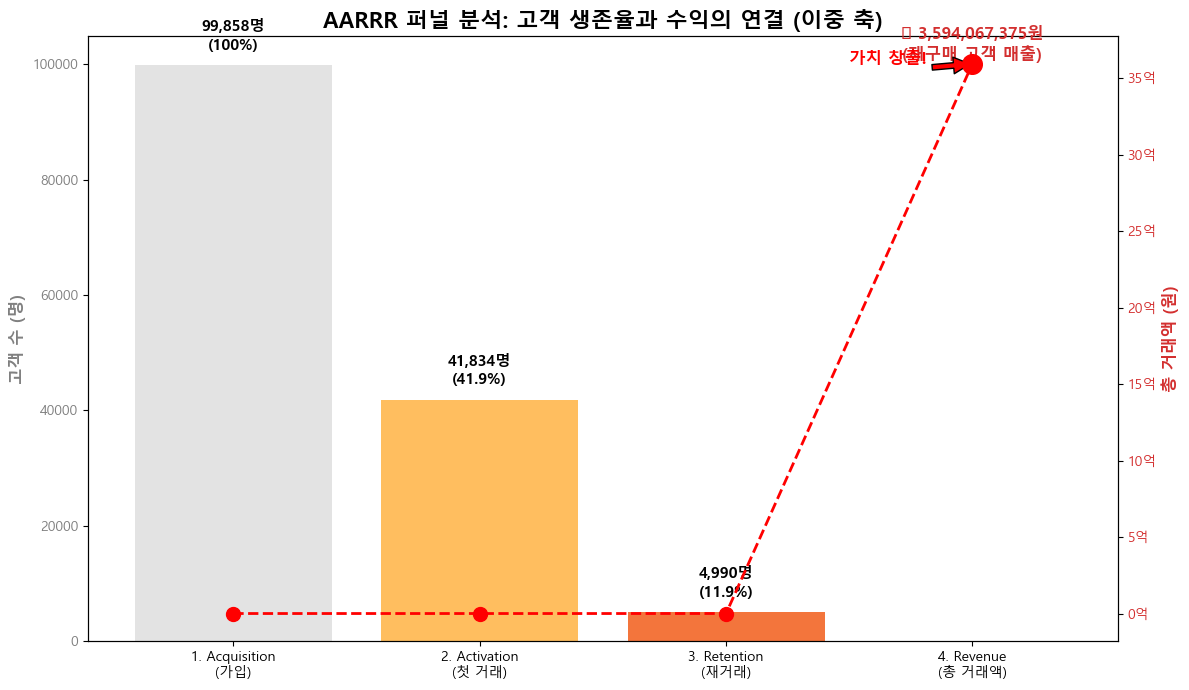

In [9]:
# 데이터 로딩 (전체 고객 대상) 앞에서 했다고 가정

from matplotlib.ticker import FuncFormatter

print("🚀 AARRR 분석 시작 (Revenue = Amount 연결)...")

# 고객별 AARRR 지표 집계
query = text(f"""
    SELECT 
        nameOrig,
        MAX(isActivation) as is_active,         -- 활성화 여부
        COUNT(*) as txn_count,                  -- 거래 횟수 (Retention용)
        SUM(amount) as total_amount             -- 총 거래액 (Revenue용)
    FROM {TABLE}
    WHERE isFraud = 0                           -- 사기 거래 제외
    GROUP BY nameOrig
""")

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

print(f"✅ 데이터 로드 완료: {len(df):,}명")

# ==========================================
# 2) AARRR 단계별 수치 계산
# ==========================================
# 1. Acquisition (획득): 전체 유입 고객 수
val_acq = len(df)

# 2. Activation (활성): 첫 거래 완료 고객 수
val_act = df[df['is_active'] == 1].shape[0]

# 3. Retention (유지): 재거래(2회 이상) 고객 수
ret_users = df[df['txn_count'] > 1]
val_ret = ret_users.shape[0]

# 4. Revenue (수익): "유지된 고객(Retained)"들이 만들어낸 총 거래액
# (활성 유저 전체의 매출을 볼 수도 있지만, 보통 퍼널은 '남은 사람들의 가치'를 봅니다)
val_rev = ret_users['total_amount'].sum()

# 퍼널 데이터프레임
# 주의: 마지막 Revenue는 단위가 '원'이므로 전환율 계산에서 제외하거나 별도 해석 필요
funnel_df = pd.DataFrame({
    'Stage': ['1. Acquisition\n(가입)', '2. Activation\n(첫 거래)', '3. Retention\n(재거래)', '4. Revenue\n(총 거래액)'],
    'Value': [val_acq, val_act, val_ret, val_rev],
    'Type': ['User', 'User', 'User', 'Money']
})

print("\n=== 📊 AARRR 퍼널 단계별 수치 ===")
print(funnel_df)
print(f"\n💰 Retention 단계 유저의 총 매출 기여액: {val_rev:,.0f}원")
print(f"👤 재구매 유저 1인당 평균 매출(ARPPU): {val_rev / val_ret:,.0f}원")

# ==========================================
# 3) 시각화 (이중 축 차트: Users vs Money)
# ==========================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# X축: 단계
stages = funnel_df['Stage']

# [왼쪽 축] User Funnel (막대 그래프)
# Revenue 단계는 User가 아니므로 0으로 처리하거나 비워둠 (여기선 3단계까지만 막대로 표현)
user_values = [val_acq, val_act, val_ret, 0] 
bars = ax1.bar(stages, user_values, color=['#E0E0E0', '#FFB74D', '#F26627', 'white'], alpha=0.9, label='고객 수 (명)')

ax1.set_ylabel('고객 수 (명)', fontsize=12, fontweight='bold', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# [오른쪽 축] Revenue (선 그래프 or 별도 막대)
ax2 = ax1.twinx()
revenue_values = [0, 0, 0, val_rev] # 마지막 단계에만 값 부여
line = ax2.plot(stages, revenue_values, color='red', marker='o', markersize=10, linewidth=2, linestyle='--', label='매출 (원)')

# 마지막 점(Revenue) 강조
ax2.scatter(3, val_rev, color='red', s=200, zorder=5)

ax2.set_ylabel('총 거래액 (원)', fontsize=12, fontweight='bold', color='#D32F2F')
ax2.tick_params(axis='y', labelcolor='#D32F2F')

# Y축 포맷 (천 단위 콤마 등) - 큰 숫자 가독성
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/100000000:,.0f}억'))

# 타이틀
plt.title("AARRR 퍼널 분석: 고객 생존율과 수익의 연결 (이중 축)", fontsize=16, fontweight='bold')

# ==========================================
# 4) 수치 라벨링 (Annotation)
# ==========================================
# 1~3단계 (User 수 및 전환율)
for i in range(3):
    count = user_values[i]
    if i == 0:
        rate_text = "100%"
    else:
        prev_count = user_values[i-1]
        rate = (count / prev_count) * 100
        rate_text = f"{rate:.1f}%"
    
    ax1.text(i, count + (val_acq * 0.02), f"{count:,}명\n({rate_text})", 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

# 4단계 (Revenue 금액)
ax2.text(3, val_rev, f"💰 {val_rev:,.0f}원\n(재구매 고객 매출)", 
         ha='center', va='bottom', fontsize=12, fontweight='bold', color='#D32F2F')

# 화살표로 연결 의미 부여 (Retention -> Revenue)
plt.annotate('가치 창출!', 
             xy=(3, val_rev), xytext=(2.5, val_rev),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

🚀 매출 기여도 분석을 위한 데이터 집계 중...

[그룹별 매출액 집계]
Status
Churned (1회성)       1.696971e+10
Retained (재구매 O)    3.594067e+09
Name: total_amount, dtype: float64


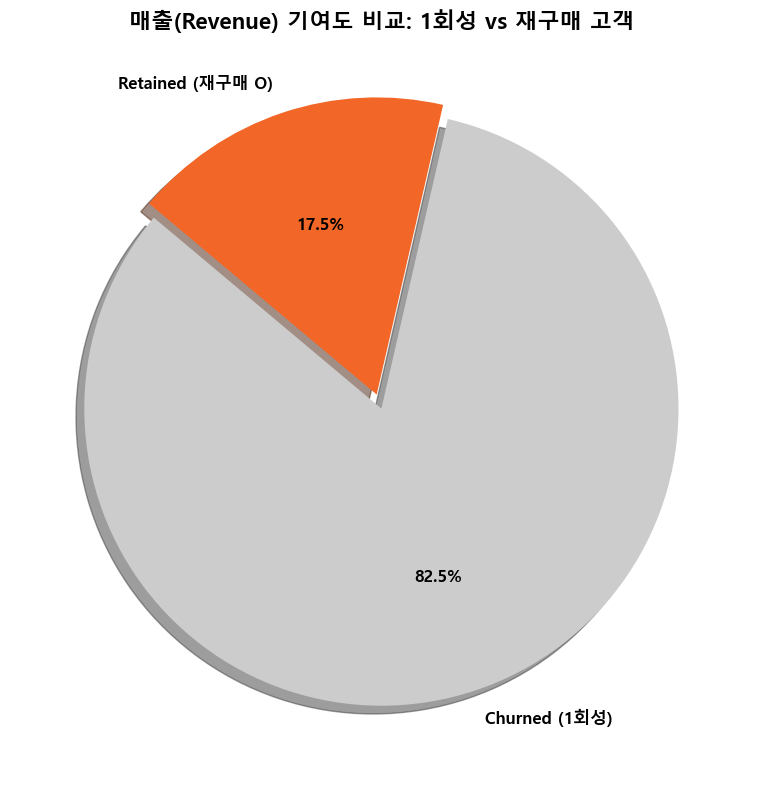

In [10]:
print("🚀 매출 기여도 분석을 위한 데이터 집계 중...")

# 고객별 거래 횟수(txn_count)와 총 거래액(total_amount) 조회
query = text(f"""
    SELECT 
        nameOrig,
        COUNT(*) as txn_count,
        SUM(amount) as total_amount
    FROM {TABLE}
    WHERE isFraud = 0  -- 사기 거래 제외
    GROUP BY nameOrig
""")

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# ==========================================
#  그룹 정의 및 매출 집계
# ==========================================
# 거래 횟수가 1회를 초과하면 'Retained', 아니면 'Churned'
df['Status'] = df['txn_count'].apply(lambda x: 'Retained (재구매 O)' if x > 1 else 'Churned (1회성)')

# 그룹별 총 매출액(Sum) 계산
rev_stat = df.groupby('Status')['total_amount'].sum()

# 보기 좋게 순서 정렬 (Retained를 강조하기 위해 순서 조정 가능)
# 여기서는 Retained와 Churned 두 개뿐이므로 바로 그립니다.

print("\n[그룹별 매출액 집계]")
print(rev_stat)

# ==========================================
#  파이차트 시각화
# ==========================================
plt.figure(figsize=(8, 8))

# 데이터와 라벨 준비
labels = rev_stat.index
sizes = rev_stat.values

# 색상 설정 (이미지와 비슷하게: Retained=주황, Churned=회색)
# 순서가 [Churned, Retained] 일 수 있으므로 라벨을 확인해서 색상 매핑
colors = []
explode = []

for label in labels:
    if 'Retained' in label:
        colors.append('#F26627')  # 진한 주황색 (강조)
        explode.append(0.05)      # 툭 튀어나오게 강조 (Explode)
    else:
        colors.append('#CCCCCC')  # 연한 회색
        explode.append(0)

# 파이차트 그리기
plt.pie(sizes, 
        labels=labels, 
        autopct='%1.1f%%',      # 소수점 1자리까지 % 표시
        startangle=140,         # 각도 돌려서 보기 좋게 배치
        colors=colors, 
        explode=explode,        # 쪼개기 효과
        shadow=True,            # 그림자 효과 (입체감)
        textprops={'fontsize': 12, 'fontweight': 'bold'}) # 글자 크기 키움

plt.title("매출(Revenue) 기여도 비교: 1회성 vs 재구매 고객", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()